Number of measure errors : %d 48
Number of measure errors : %d 65
Number of measure errors : %d 78


/var/folders/3b/gndgh3_j0mn3vgdx4cl1k6g00000gn/T/ipykernel_94147/21821539.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=' ', y='Error [rad]', data=errors_melted, palette="Greens")


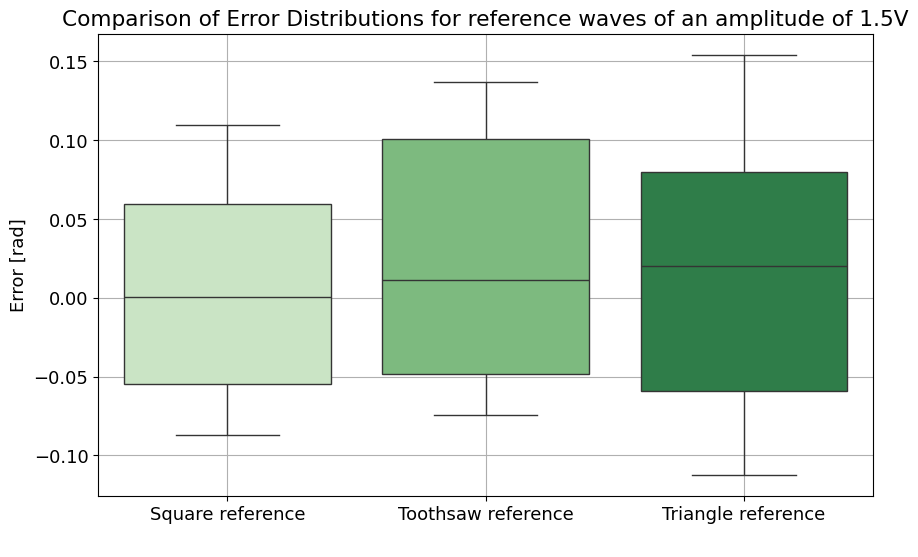

,min,25%,50%,75%,max
Square reference,-0.087201,-0.054985,0.000175,0.059209,0.109705
Toothsaw reference,-0.074635,-0.048572,0.011003,0.100898,0.136800
Triangle reference,-0.112275,-0.059409,0.020203,0.079726,0.154145


In [19]:
from src.data_processing import process_file
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d

# Select the measurements
file_path_exp = [
    "data/validation_exp/PWM_control_exp/exp3_square_1_5.txt",
    "data/validation_exp/PWM_control_exp/exp3_tooth_1_5.txt",
    "data/validation_exp/PWM_control_exp/exp3_triangle_1_5.txt"
]
file_path_exp = [
    "data/validation_exp/PWM_control_exp/exp2_square.txt",
    "data/validation_exp/PWM_control_exp/exp2_tooth.txt",
    "data/validation_exp/PWM_control_exp/exp2_triangle.txt"
]

real_data = [process_file(fp, delta_t=0.02) for fp in file_path_exp]

# Adjusting position
for df in real_data:
    df['DXL_Position'] -= np.pi / 2

# Load simulation data and paths
file_path_sim = [
    "data/validation_exp/simulation/normal/simu_square_amp1_5.csv",
    "data/validation_exp/simulation/normal/simu_tooth_amp1_5.csv",
    "data/validation_exp/simulation/normal/simu_triangle_amp1_5.csv"
]
file_path_sim = [
    "data/validation_exp/simulation/normal/simu_square_amp3.csv",
    "data/validation_exp/simulation/normal/simu_tooth_amp3.csv",
    "data/validation_exp/simulation/normal/simu_triangle_amp3.csv"
]
file_path_sim = [
    "data/validation_exp/simulation/models/simu_model2_exp1.csv",
    "data/validation_exp/simulation/models/simu_model2_exp2.csv",
    "data/validation_exp/simulation/models/simu_model2_exp3.csv"
]
# file_path_sim = [
#     "data/validation_exp/simulation/models/simu_model2_exp4.csv",
#     "data/validation_exp/simulation/models/simu_model2_exp5.csv",
#     "data/validation_exp/simulation/models/simu_model2_exp6.csv"
# ]

sim_interp_positions = []
errors = []

for i, fp in enumerate(file_path_sim):
    sim_data = pd.read_csv(fp)
    interpolator = interp1d(sim_data['Time'], sim_data['Position'], kind='linear', fill_value="extrapolate")
    
    # Interpolating for each real_data time series
    interpolated_positions = interpolator(real_data[i]['t'])
    sim_interp_positions.append(interpolated_positions)
    
    # Calculate error for each experiment
    error = real_data[i]['DXL_Position'] - interpolated_positions
    errors.append(error)

# Preparing data for boxplot
errors_combined = pd.DataFrame({'Square reference': errors[0], 'Toothsaw reference': errors[1], 'Triangle reference': errors[2]})
errors_melted = errors_combined.melt(value_name='Error [rad]', var_name=' ')

# # Plotting
# plt.figure(figsize=(10, 6))
# sns.boxplot(x=' ', y='Error', data=errors_melted)
# plt.title('Comparison of Error Distributions for reference waves of amplitude 3V')
# plt.grid()
# plt.show()

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x=' ', y='Error [rad]', data=errors_melted, palette="Greens")
plt.title('Comparison of Error Distributions for reference waves of an amplitude of 1.5V')
plt.grid()

# Show the box plot and print the statistical values
plt.show()
errors_combined.describe().transpose().loc[:, ['min', '25%', '50%', '75%', 'max']]


In [5]:
0.22 + (2.6657 * 3.6103 / 9.3756)

1.246491820256837

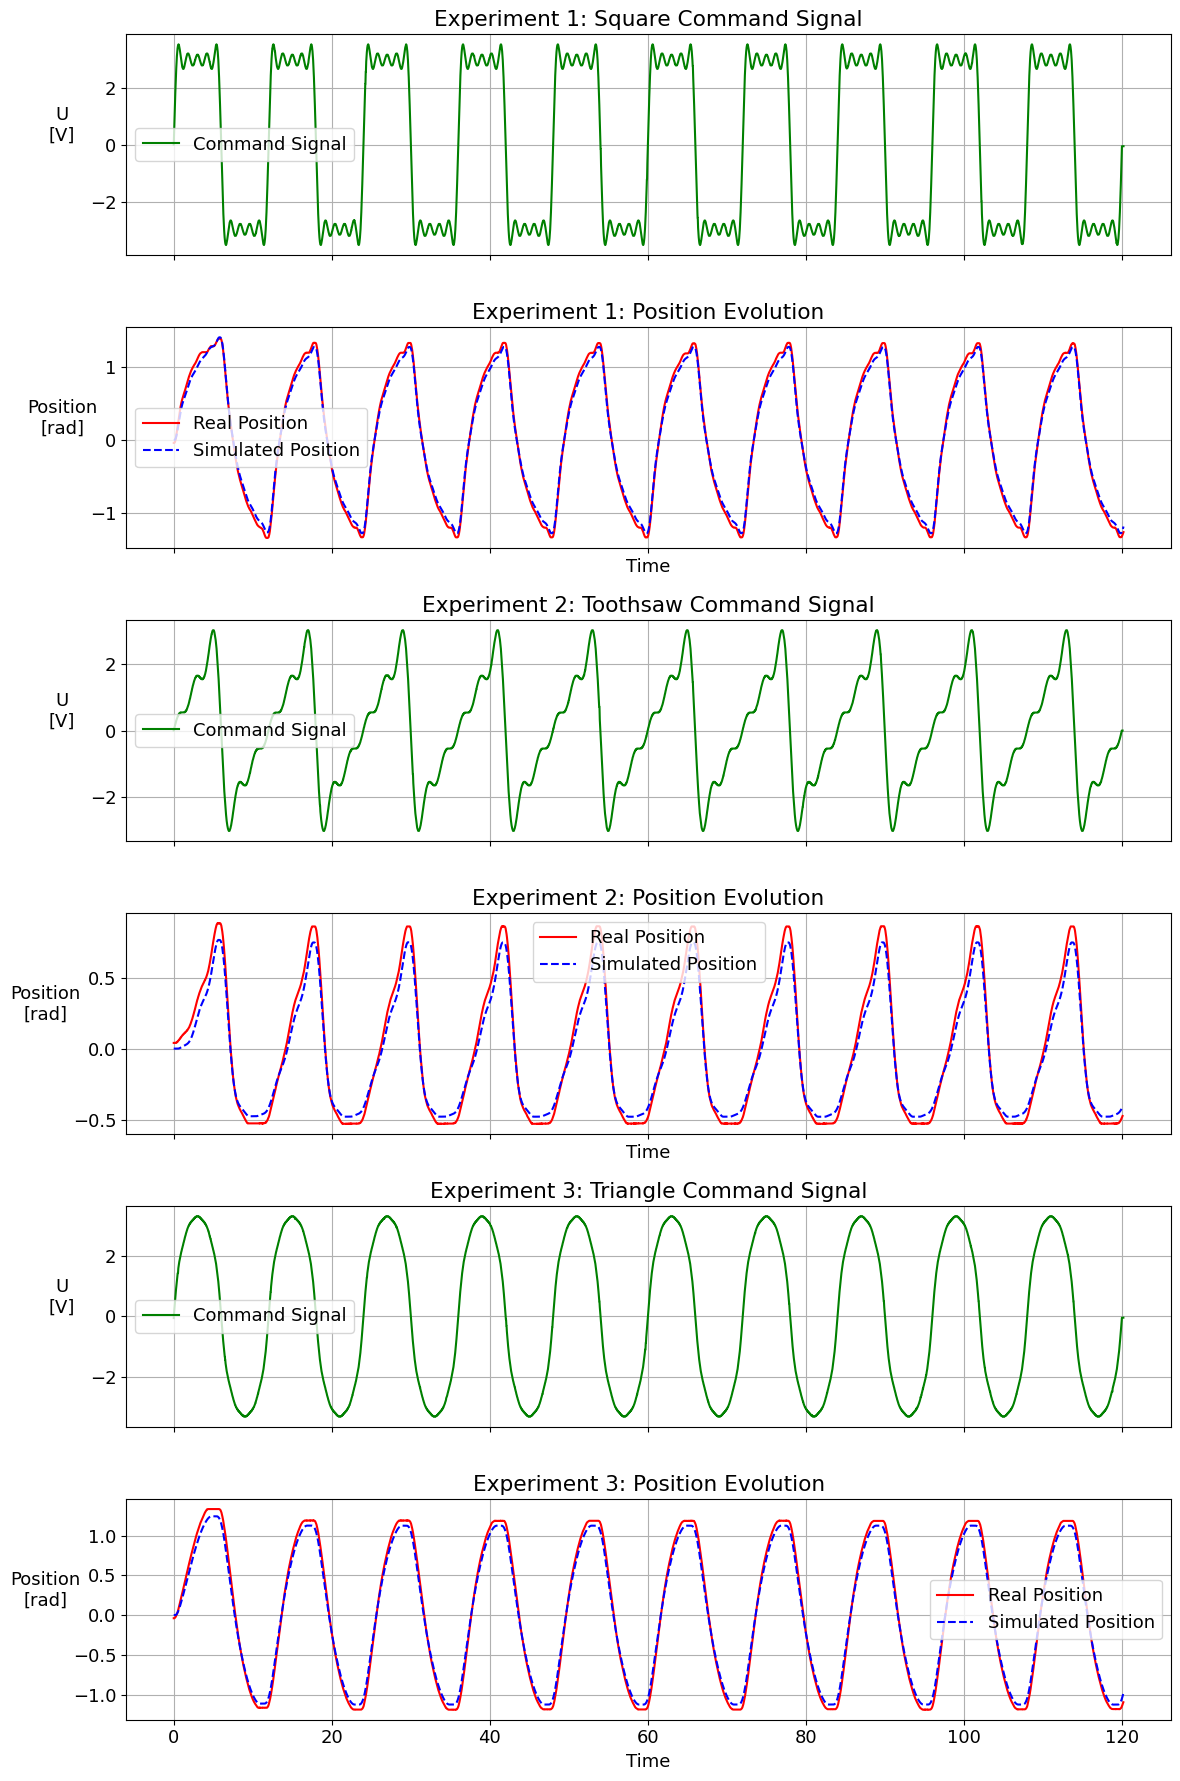

In [20]:
# Assuming real_data and sim_interp_positions are already correctly processed
import matplotlib as mpl

# Set the font size globally
mpl.rcParams.update({'font.size': 13})  # Change 14 to your desired font size

fig, axs = plt.subplots(len(real_data) * 2, 1, figsize=(12, 6 * len(real_data)), sharex=True)

for i in range(len(real_data)):
    # Command signal ('U' column) from real_data
    ax_top = axs[i * 2]
    ax_top.plot(real_data[i]['t'], real_data[i]['U'], label='Command Signal', color='green')
    if i == 0:
        name = "Square"
    elif i == 1:
        name = "Toothsaw"
    else:
        name = "Triangle"
    ax_top.set_title(f'Experiment {i+1}: {name} Command Signal')
    ax_top.set_ylabel('U\n[V]', labelpad=20, rotation=0)
    ax_top.grid(True)
    ax_top.legend()

    # Position evolutions for real and simulated data
    ax_bottom = axs[i * 2 + 1]
    ax_bottom.plot(real_data[i]['t'], real_data[i]['DXL_Position'], label='Real Position', color='red')
    ax_bottom.plot(real_data[i]['t'], sim_interp_positions[i], label='Simulated Position', linestyle='--', color='blue')
    ax_bottom.set_title(f'Experiment {i+1}: Position Evolution')
    ax_bottom.set_ylabel('Position\n[rad]', labelpad=20, rotation=0)
    ax_bottom.set_xlabel('Time')
    ax_bottom.grid(True)
    ax_bottom.legend()

plt.tight_layout()
plt.show()


Some analysis

In [40]:
from sklearn.metrics import r2_score
import numpy as np

# Assuming errors, real_data, and sim_interp_positions are already defined from the previous steps

def nrmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    nrmse_value = rmse / np.std(y_true)
    return nrmse_value

def fit_percentage(y_true, y_pred):
    numerator = np.sum((y_true - y_pred)**2)
    denominator = np.sum((y_true - np.mean(y_true))**2)
    fit_perc = (1 - numerator/denominator) * 100
    return fit_perc

# Loop through each experiment to calculate metrics
experiment_names = ["Square Wave", "Tooth Wave", "Triangle Wave"]
for i in range(len(experiment_names)):
    y_true = real_data[i]['DXL_Position'].values
    y_pred = sim_interp_positions[i]

    # Calculate R-squared
    r_squared = r2_score(y_true, y_pred)
    print(f"{experiment_names[i]} - R-squared: {r_squared:.4f}")

    # Calculate NRMSE
    nrmse_value = nrmse(y_true, y_pred)
    print(f"{experiment_names[i]} - NRMSE: {nrmse_value:.4f}")

    # Calculate Fit Percentage
    fit_perc = fit_percentage(y_true, y_pred)
    print(f"{experiment_names[i]} - Fit Percentage: {fit_perc:.2f}%\n")


Square Wave - R-squared: 0.9971
Square Wave - NRMSE: 0.0537
Square Wave - Fit Percentage: 99.71%

Tooth Wave - R-squared: 0.9789
Tooth Wave - NRMSE: 0.1453
Tooth Wave - Fit Percentage: 97.89%

Triangle Wave - R-squared: 0.9954
Triangle Wave - NRMSE: 0.0676
Triangle Wave - Fit Percentage: 99.54%

